In [1]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from causalgraphicalmodels import CausalGraphicalModel
from dowhy import CausalModel
import dowhy.datasets
from networkx.drawing.nx_pydot import write_dot
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite.gml import write_gml


In [2]:
def gen_estimate(graph, df, treatment , outcome ):
        # With graph
    model=CausalModel(
            data = df,
            treatment=treatment,
            outcome=outcome,
            graph=graph
            )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    causal_estimate = model.estimate_effect(identified_estimand,
            method_name="backdoor.linear_regression",target_units="ate")
    print(causal_estimate)
    return causal_estimate.value

In [3]:
def get_graph(minutes_x):
    G = nx.DiGraph()
    G.add_edges_from(
        [
            (minutes_x,"mia_points"),     
            (minutes_x,"Points"), 
            (minutes_x,"Fouls"), 
            (minutes_x,"Assists"), 
            ("Points", "mia_points"),
            ("Assists", "mia_points"),
            ("Fouls", "mia_points"),
            ("is_home", "mia_points"),
    ])

    write_gml(G, 'testgml')
    with open('testgml') as f: s = f.read()
    return s

In [4]:
def get_df_minutes(df):
    df['minute<25']=0
    slice_indices =df['Minutes']<25
    df.loc[slice_indices,'minute<25']=1


    df['minute<30']=0
    slice_indices =(df['Minutes']<30)  
    df.loc[slice_indices,'minute<30']=1

    df['minute<35']=0
    slice_indices =(df['Minutes']<35)  
    df.loc[slice_indices,'minute<35']=1


    df['minute<40']=0
    slice_indices =(df['Minutes']<40)  
    df.loc[slice_indices,'minute<40']=1
    
    df['minute<45']=0
    slice_indices =(df['Minutes']<45)  
    df.loc[slice_indices,'minute<45']=1

    return df

In [25]:
def dowhy(df, treatment_columns, player):
    df = get_df_minutes(df)
    treatment_columns = ["minute<25","minute<30", "minute<35", "minute<40"]#, "minute<45"]
    estimates = []
    df = df.groupby('season')
    for t in treatment_columns:
        for season, split_df in df:
            try:
                est = gen_estimate(get_graph(t),split_df,t,"mia_points")
                estimates. append({'treatment':t, 'outcome':"mia_points", 'season':season,'estimate_'+player:est})
            except:
                estimates. append({'treatment':t, 'season':season, 'estimate':None})
    estimate_df=pd.DataFrame(estimates)
    return estimate_df.sort_values('season')

# Tyler Herro

In [26]:
herro_df = pd.read_csv('/Users/sdy/Desktop/Casual Inference/herro.csv')
herro_df = herro_df.drop(['Unnamed: 0'],axis=1)
herro_df = herro_df.drop(["Date","HomePoints",
                         "AwayPoints", "HomeTeamAbbreviation","AwayTeamAbbreviation"],axis=1)

In [8]:
herro_df

,Name,Minutes,Points,Fouls,Assists,Rebounds,Turnovers,FtPoints,FG2A,Fg2Pct,FG3A,Fg3Pct,GameId,season_type,season,outcome,is_home,mia_points
0,Tyler Herro,33.900000,14.0,2.0,1.0,8.0,1.0,1.0,12.0,0.416667,2.0,0.500000,21900007,Regular Season,2019-20,1,1,120.0
1,Tyler Herro,32.333333,14.0,3.0,NaN,5.0,3.0,NaN,9.0,0.444444,7.0,0.285714,21900026,Regular Season,2019-20,1,0,131.0
2,Tyler Herro,35.033333,8.0,3.0,4.0,5.0,5.0,1.0,3.0,0.666667,6.0,0.166667,21900039,Regular Season,2019-20,0,0,109.0
3,Tyler Herro,29.116667,29.0,NaN,2.0,7.0,2.0,12.0,5.0,0.800000,4.0,0.750000,21900052,Regular Season,2019-20,1,1,112.0
4,Tyler Herro,30.450000,17.0,1.0,3.0,4.0,1.0,NaN,7.0,0.571429,9.0,0.333333,21900066,Regular Season,2019-20,1,0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Tyler Herro,15.950000,10.0,NaN,1.0,3.0,NaN,NaN,10.0,0.500000,2.0,NaN,42100206,Playoffs,2021-22,1,0,99.0
211,Tyler Herro,27.466667,18.0,1.0,3.0,8.0,4.0,3.0,10.0,0.600000,5.0,0.200000,42100301,Playoffs,2021-22,1,1,118.0
212,Tyler Herro,23.666667,11.0,2.0,3.0,1.0,2.0,1.0,8.0,0.625000,3.0,NaN,42100302,Playoffs,2021-22,0,1,102.0
213,Tyler Herro,20.216667,8.0,1.0,3.0,2.0,NaN,NaN,9.0,0.444444,6.0,NaN,42100303,Playoffs,2021-22,1,0,109.0


In [10]:
herro_df_regular = herro_df[herro_df['season_type'] == 'Regular Season']
herro_df_playoff = herro_df[herro_df['season_type'] == 'Playoffs']

In [13]:
G = nx.DiGraph()
G.add_edges_from(
    [
        ("Minutes", "Assists"), 
        ("Minutes", "Points"), 
        ("Minutes", "Fouls"),
        ("Minutes", "mia_points"),
        ("Points", "mia_points"),
        ("Assists", "mia_points"),
        ("Fouls", "mia_points"),
        ("is_home", "mia_points"),
  
])
write_gml(G, 'testgml')
with open('testgml') as f: s = f.read()
    

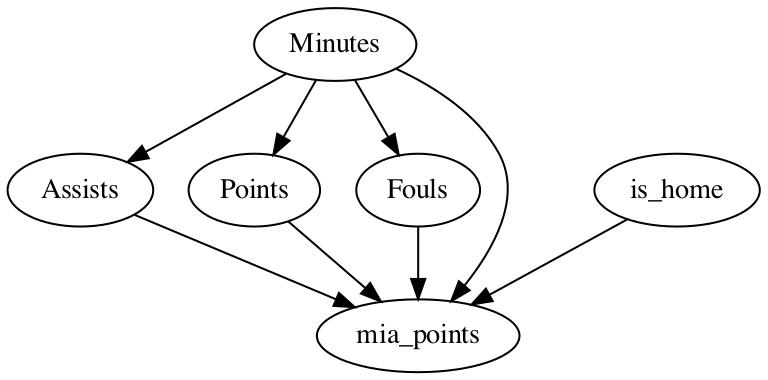

In [14]:
import pygraphviz

model= dowhy.CausalModel(
        data = herro_df,
        graph=s,
        treatment= 'Minutes',
        outcome= 'mia_points')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [51]:
treatment_columns = ["minute<25","minute<30", "minute<35", "minute<40"]#, "minute<45"]
herro_all = dowhy(herro_df, treatment_columns, 'herro')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -1.4204260651628715

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -3.114881389092716

*

In [52]:
herro_regular = dowhy(herro_df_regular, treatment_columns, 'herro')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -2.533838383838358

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: 2.012345679012384

***

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<25']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<30']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [53]:
herro2122 = herro_df_playoff[herro_df_playoff['season'] == '2021-22']
herro2122['Minutes'].max()

33.7333333333333

In [54]:
herro_playoff = dowhy(herro_df_playoff, treatment_columns, 'herro')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: 0.0

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -9.749999999999929

*** Causal Estima

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<25']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<30']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [56]:
herro_all['estimate_all'] = herro_all['estimate_herro'] 
herro_all['estimate_regular'] = herro_regular['estimate_herro'] 
herro_all['estimate_playoff'] = herro_playoff['estimate_herro'] 

In [59]:
herro_all.drop('estimate_herro',axis=1)

,treatment,outcome,season,estimate_all,estimate_regular,estimate_playoff
0,minute<25,mia_points,2019-20,-1.420426,-2.533838,0.000000
3,minute<30,mia_points,2019-20,0.021644,-2.480519,8.396825
6,minute<35,mia_points,2019-20,2.112138,1.909818,1.611111
9,minute<40,mia_points,2019-20,-3.361111,-1.607692,-6.140212
1,minute<25,mia_points,2020-21,-3.114881,2.012346,-9.750000
4,minute<30,mia_points,2020-21,-5.834660,-5.214649,-9.750000
7,minute<35,mia_points,2020-21,-10.702821,-9.984958,46.750000
10,minute<40,mia_points,2020-21,-4.177456,-3.459616,46.750000
2,minute<25,mia_points,2021-22,-1.728731,-4.320169,0.850000
5,minute<30,mia_points,2021-22,-4.744809,-3.882931,-4.400000


# Jimmy Butler

In [28]:
jimmy_df = pd.read_csv('/Users/sdy/Desktop/Casual Inference/jimmy.csv')
jimmy_df = jimmy_df.drop(['Unnamed: 0'],axis=1)
jimmy_df_mia = jimmy_df[(jimmy_df.season=="2019-20") | (jimmy_df.season=="2020-21") | (jimmy_df.season=="2021-22")]

In [29]:
jimmy_df_mia.head(10)

,Name,Minutes,Points,Fouls,Assists,Rebounds,Turnovers,FtPoints,FG2A,Fg2Pct,...,Date,HomePoints,AwayPoints,HomeTeamAbbreviation,AwayTeamAbbreviation,season_type,season,outcome,is_home,mia_points
19,Jimmy Butler,30.666667,21.0,1.0,2.0,5.0,4.0,10.0,9.0,0.444444,...,2019-10-29,112.0,97.0,MIA,ATL,Regular Season,2019-20,1,1,112.0
20,Jimmy Butler,35.183333,5.0,1.0,11.0,9.0,4.0,1.0,8.0,0.250000,...,2019-10-31,97.0,106.0,ATL,MIA,Regular Season,2019-20,1,0,106.0
21,Jimmy Butler,27.450000,18.0,2.0,9.0,7.0,1.0,2.0,9.0,0.555556,...,2019-11-03,129.0,100.0,MIA,HOU,Regular Season,2019-20,1,1,129.0
22,Jimmy Butler,29.300000,16.0,NaN,4.0,7.0,3.0,10.0,9.0,0.333333,...,2019-11-05,109.0,89.0,DEN,MIA,Regular Season,2019-20,0,0,89.0
23,Jimmy Butler,33.983333,34.0,4.0,4.0,5.0,1.0,10.0,14.0,0.642857,...,2019-11-07,108.0,124.0,PHX,MIA,Regular Season,2019-20,1,0,124.0
24,Jimmy Butler,38.100000,22.0,NaN,3.0,6.0,NaN,8.0,12.0,0.583333,...,2019-11-08,95.0,80.0,LAL,MIA,Regular Season,2019-20,0,0,80.0
25,Jimmy Butler,38.950000,20.0,NaN,13.0,3.0,NaN,8.0,11.0,0.545455,...,2019-11-12,117.0,108.0,MIA,DET,Regular Season,2019-20,1,1,117.0
26,Jimmy Butler,38.816667,14.0,2.0,6.0,2.0,4.0,NaN,9.0,0.777778,...,2019-11-14,97.0,108.0,CLE,MIA,Regular Season,2019-20,1,0,108.0
27,Jimmy Butler,37.700000,16.0,NaN,13.0,8.0,6.0,7.0,9.0,0.333333,...,2019-11-16,109.0,94.0,MIA,NOP,Regular Season,2019-20,1,1,109.0
28,Jimmy Butler,32.433333,21.0,2.0,5.0,5.0,3.0,13.0,12.0,0.083333,...,2019-11-20,124.0,100.0,MIA,CLE,Regular Season,2019-20,1,1,124.0


In [30]:
jimmy_df_regular = jimmy_df_mia[jimmy_df_mia['season_type'] == 'Regular Season']
jimmy_df_playoff = jimmy_df_mia[jimmy_df_mia['season_type'] == 'Playoffs']

In [32]:
jimmy_df_playoff['Minutes'].max()

48.0

In [60]:
treatment_columns = ["minute<25","minute<30", "minute<35", "minute<40", "minute<45"]
jimmy_all = dowhy(jimmy_df_mia, treatment_columns, 'jimmy')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -8.380413057961249

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: 13.235449735449663

**

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<25']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<30']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [61]:
jimmy_regular = dowhy(jimmy_df_regular, treatment_columns, 'jimmy')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -4.589285714285751

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: 12.53230769230781

***

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<25']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<30']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [63]:
jimmy_df_playoff['Minutes'].min()

19.5

In [64]:
jimmy_playoff = dowhy(jimmy_df_playoff, treatment_columns, 'jimmy')

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: -8.524999999999977

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[miaₚₒᵢₙₜₛ])
d[minute<25]              
Estimand assumption 1, Unconfoundedness: If U→{minute<25} and U→mia_points then P(mia_points|minute<25,,U) = P(mia_points|minute<25,)

## Realized estimand
b: mia_points~minute<25+minute<25*is_home
Target units: ate

## Estimate
Mean value: 0.0

*** Causal Estima

/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<25']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute<30']=0
/var/folders/kw/7ltwlxyn2rsfmwwm5nltr1pr0000gn/T/ipykernel_17556/3966458671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [66]:
jimmy_all['estimate_all'] = jimmy_all['estimate_jimmy'] 
jimmy_all['estimate_regular'] = jimmy_regular['estimate_jimmy'] 
jimmy_all['estimate_playoff'] = jimmy_playoff['estimate_jimmy']

In [68]:
jimmy = jimmy_playoff[jimmy_playoff['season'] == '2019-20']
jimmy

,treatment,outcome,season,estimate_jimmy
0,minute<25,mia_points,2019-20,-8.525000
3,minute<30,mia_points,2019-20,-8.525000
6,minute<35,mia_points,2019-20,-8.714286
9,minute<40,mia_points,2019-20,3.316327


In [67]:
jimmy_all.drop('estimate_jimmy',axis=1)

,treatment,outcome,season,estimate_all,estimate_regular,estimate_playoff
0,minute<25,mia_points,2019-20,-8.380413,-4.589286,-8.525000
3,minute<30,mia_points,2019-20,5.099156,7.021739,-8.525000
6,minute<35,mia_points,2019-20,0.907344,1.807644,-8.714286
9,minute<40,mia_points,2019-20,-2.618774,-9.845442,3.316327
1,minute<25,mia_points,2020-21,13.235450,12.532308,0.000000
4,minute<30,mia_points,2020-21,4.698810,3.828455,0.000000
7,minute<35,mia_points,2020-21,0.768720,-0.272261,0.000000
10,minute<40,mia_points,2020-21,-0.530782,-0.392543,-11.250000
2,minute<25,mia_points,2021-22,-4.155503,-4.127221,4.625000
5,minute<30,mia_points,2021-22,0.828037,1.795956,-10.366667


# Bam Adebayo

In [80]:
bam_df = pd.read_csv('/Users/sdy/Desktop/Casual Inference/bam2122.csv')
bam_df = bam_df.drop(['Unnamed: 0'],axis=1)
bam_df.head(10)

,Name,Minutes,Points,Fouls,Assists,GameId,Date,HomePoints,AwayPoints,HomeTeamAbbreviation,AwayTeamAbbreviation,season_type,season,outcome,is_home,mia_points
0,Bam Adebayo,23.166667,20.0,3.0,1.0,22100015,2021-10-21,137.0,95.0,MIA,MIL,Regular Season,2021-22,1,1,137.0
1,Bam Adebayo,39.350000,17.0,4.0,3.0,22100028,2021-10-23,102.0,91.0,IND,MIA,Regular Season,2021-22,0,0,91.0
2,Bam Adebayo,29.033333,16.0,1.0,2.0,22100045,2021-10-25,107.0,90.0,MIA,ORL,Regular Season,2021-22,1,1,107.0
3,Bam Adebayo,30.150000,24.0,3.0,NaN,22100057,2021-10-27,93.0,106.0,BKN,MIA,Regular Season,2021-22,1,0,106.0
4,Bam Adebayo,35.716667,26.0,2.0,2.0,22100073,2021-10-29,114.0,99.0,MIA,CHA,Regular Season,2021-22,1,1,114.0
5,Bam Adebayo,32.700000,22.0,3.0,1.0,22100104,2021-11-02,110.0,125.0,DAL,MIA,Regular Season,2021-22,1,0,125.0
6,Bam Adebayo,29.783333,13.0,2.0,4.0,22100121,2021-11-04,78.0,95.0,MIA,BOS,Regular Season,2021-22,0,1,78.0
7,Bam Adebayo,35.716667,17.0,4.0,6.0,22100134,2021-11-06,118.0,115.0,MIA,UTA,Regular Season,2021-22,1,1,118.0
8,Bam Adebayo,31.066667,10.0,2.0,2.0,22100151,2021-11-08,113.0,96.0,DEN,MIA,Regular Season,2021-22,0,0,96.0
9,Bam Adebayo,33.616667,28.0,6.0,4.0,22100170,2021-11-10,120.0,117.0,LAL,MIA,Regular Season,2021-22,0,0,117.0


# Kyle Lowry

In [89]:
kyle_df = pd.read_csv('/Users/sdy/Desktop/Casual Inference/kyle2122.csv')
kyle_df = kyle_df.drop(['Unnamed: 0'],axis=1)
kyle_df.head(10)

,Name,Minutes,Points,Fouls,Assists,GameId,Date,HomePoints,AwayPoints,HomeTeamAbbreviation,AwayTeamAbbreviation,season_type,season,outcome,is_home,mia_points
0,Kyle Lowry,24.466667,5.0,2.0,6.0,22100015,2021-10-21,137.0,95.0,MIA,MIL,Regular Season,2021-22,1,1,137.0
1,Kyle Lowry,31.183333,9.0,4.0,8.0,22100045,2021-10-25,107.0,90.0,MIA,ORL,Regular Season,2021-22,1,1,107.0
2,Kyle Lowry,34.150000,9.0,2.0,9.0,22100057,2021-10-27,93.0,106.0,BKN,MIA,Regular Season,2021-22,1,0,106.0
3,Kyle Lowry,36.316667,4.0,3.0,5.0,22100073,2021-10-29,114.0,99.0,MIA,CHA,Regular Season,2021-22,1,1,114.0
4,Kyle Lowry,29.300000,15.0,1.0,8.0,22100084,2021-10-30,103.0,129.0,MEM,MIA,Regular Season,2021-22,1,0,129.0
5,Kyle Lowry,35.700000,22.0,2.0,9.0,22100104,2021-11-02,110.0,125.0,DAL,MIA,Regular Season,2021-22,1,0,125.0
6,Kyle Lowry,28.050000,6.0,2.0,5.0,22100121,2021-11-04,78.0,95.0,MIA,BOS,Regular Season,2021-22,0,1,78.0
7,Kyle Lowry,36.466667,20.0,3.0,10.0,22100134,2021-11-06,118.0,115.0,MIA,UTA,Regular Season,2021-22,1,1,118.0
8,Kyle Lowry,37.433333,NaN,4.0,4.0,22100151,2021-11-08,113.0,96.0,DEN,MIA,Regular Season,2021-22,0,0,96.0
9,Kyle Lowry,46.516667,18.0,4.0,11.0,22100170,2021-11-10,120.0,117.0,LAL,MIA,Regular Season,2021-22,0,0,117.0
